## Parametric Analysis Script

In [16]:
from dataclasses import dataclass
from typing import List
import matplotlib.pyplot as plt

### Data Class definitions for EP1

In [23]:
# Define data structures

## Dataclass for buildings

    
@dataclass
class EnvelopeComponent:
    name: str
    area: float  # m²
    u_value: float  # W/m²K

@dataclass
class Ventilation:
    ach: float  # air changes per hour
    volume: float  # m³
    heat_recovery_efficiency: float = 0.0  # default 0%, set to 0.8 for 80% recovery


## Energy & Solar gains to substract from internal gains to calculate EP1

@dataclass
class InternalGains:
    people_gain_w_per_m2: float
    equipment_gain_w_per_m2: float
    lighting_gain_w_per_m2: float
    area: float  # m²

@dataclass
class SolarGains:
    window_area: float  # m²
    g_value: float
    shading_factor: float
    solar_radiation_kwh_per_m2_year: float




## Heating systems for EP2
@dataclass
class HeatingSystem:
    name: str
    efficiency: float  # Between 0–1 (or COP for HP)
    energy_carrier: str  # 'gas' or 'electric'


## Renewables for EP3
@dataclass
class RenewableEnergySystem:
    type: str  # e.g., 'PV'
    annual_production_kwh: float  # Total kWh/year from renewables


@dataclass
class Building:
    heated_area: float  # m²
    heated_volume: float  # m³
    envelope: List[EnvelopeComponent]
    ventilation: Ventilation
    internal_gains: InternalGains
    solar_gains: SolarGains
    delta_t: float  # °C
    hdd: int  # heating degree days


### EP1 Calculation functions 

In [26]:
# Calculation functions
def calculate_transmission_losses(building: Building) -> float:
    total_u_a = sum(comp.u_value * comp.area for comp in building.envelope)
    return total_u_a * building.hdd * 24 * 3600 / 1_000_000  # MJ/year

def calculate_ventilation_losses(building: Building) -> float:
    q_vent = 0.33 * building.ventilation.ach * building.ventilation.volume * building.hdd
    return q_vent * (1 - building.ventilation.heat_recovery_efficiency)

    
def calculate_internal_gains(building: Building) -> float:
    gain_total = (
        building.internal_gains.people_gain_w_per_m2 +
        building.internal_gains.equipment_gain_w_per_m2 +
        building.internal_gains.lighting_gain_w_per_m2
    )
    return gain_total * building.internal_gains.area * 24 * 365 / 1000  # MJ/year

def calculate_solar_gains(building: Building) -> float:
    gain_kwh = (
        building.solar_gains.window_area *
        building.solar_gains.solar_radiation_kwh_per_m2_year *
        building.solar_gains.g_value *
        building.solar_gains.shading_factor
    )
    return gain_kwh * 3.6  # MJ/year

def calculate_ep1(building: Building) -> float:
    q_trans = calculate_transmission_losses(building)
    q_vent = calculate_ventilation_losses(building)
    q_internal = calculate_internal_gains(building)
    q_solar = calculate_solar_gains(building)
    net_heating_demand = max(q_trans + q_vent - q_internal - q_solar, 0)
    return net_heating_demand / building.heated_area  # MJ/m².year


### Calculations for EP2

In [61]:


def calculate_ep2(building: Building, system: HeatingSystem) -> float:
    """Calculate EP2: Primary fossil energy use in MJ/year"""
    q_trans = calculate_transmission_losses(building)
    q_vent = calculate_ventilation_losses(building)
    q_internal = calculate_internal_gains(building)
    q_solar = calculate_solar_gains(building)

    q_heating = max(q_trans + q_vent - q_internal - q_solar, 0)  # net energy demand

    # Primary energy factor
    primary_factor = 1.0 if system.energy_carrier == 'gas' else 2.56

    # Final energy needed from system
    final_energy = q_heating / system.efficiency
    ep2 = final_energy * primary_factor  # MJ/year
    return ep2

def calculate_ep2_per_m2(total_kwh: float, building: Building) -> float:
    """Calculate EP2 in kWh/m²·year using total energy use and heated area"""
    if building.heated_area <= 0:
        raise ValueError("Heated area must be greater than zero.")
    return total_kwh / building.heated_area


def calculate_ep2_components(building: Building, system: HeatingSystem):
    q_trans = calculate_transmission_losses(building)
    q_vent = calculate_ventilation_losses(building)
    q_internal = calculate_internal_gains(building)
    q_solar = calculate_solar_gains(building)

    q_heating = max(q_trans + q_vent - q_internal - q_solar, 0)
    primary_factor = 1.0 if system.energy_carrier == 'gas' else 2.56
    final_energy = q_heating / system.efficiency
    ep2 = final_energy * primary_factor

    return q_heating, final_energy, ep2

### Calculations for EP3

In [32]:

def calculate_ep3(ep2: float, renewable: RenewableEnergySystem) -> float:
    """Calculate EP3: % of primary energy covered by renewables"""
    renewable_mj = renewable.annual_production_kwh * 3.6
    share = renewable_mj / ep2 if ep2 > 0 else 0
    return min(share * 100, 100)  # capped at 100%

## Tutorial

### EP1

In [36]:
# --- Improved Test Building ---
improved_building = Building(
    heated_area=100.0,
    heated_volume=270.0,
    envelope=[
        EnvelopeComponent("Wall", 100.0, 0.4),
        EnvelopeComponent("Roof", 100.0, 0.3),
        EnvelopeComponent("Floor", 100.0, 0.4),
        EnvelopeComponent("Window", 16.0, 1.8)
    ],
    ventilation=Ventilation(ach=0.35, volume=270.0, heat_recovery_efficiency=0.0),
    internal_gains=InternalGains(3.0, 4.0, 2.5, 100.0),
    solar_gains=SolarGains(16.0, 0.6, 0.85, 450.0),
    delta_t=15.0,
    hdd=2600
)

# Calculate and print EP1
ep1 = calculate_ep1(improved_building)
print(f"EP1: {ep1:.2f} MJ/m²·year ≈ {ep1/3.6:.2f} kWh/m²·year")

EP1: 907.20 MJ/m²·year ≈ 252.00 kWh/m²·year


### EP2

In [39]:
# Example system
gas_boiler = HeatingSystem(name="Gas Boiler", efficiency=0.94, energy_carrier="gas")

# Calculate EP2
ep2 = calculate_ep2(improved_building, gas_boiler)
print(f"EP2: {ep2:.2f} MJ/year")
ep2kWh= ep2/3.6
print(f"EP2: {ep2kWh:.2f} MJ/year")

ep2perm2 = calculate_ep2_per_m2(ep2kWh, improved_building)

print(f"EP2 per square meter: {ep2perm2:.2f} MJ/m2*year")

EP2: 96510.46 MJ/year
EP2: 26808.46 MJ/year
EP2 per square meter: 268.08 MJ/m2*year


### EP3

In [42]:
# Example PV system
pv = RenewableEnergySystem(type="PV", annual_production_kwh=4000)

# Calculate EP3
ep3 = calculate_ep3(ep2, pv)
print(f"EP3: {ep3:.2f}%")

EP3: 14.92%


| Energy Label | Typical EP2 Range (kWh/m²·year) | Approx. MJ/m²·year |
| ------------ | ------------------------------- | ------------------ |
| A++++        | 0 – 15                          | 0 – 54             |
| A+++         | 15 – 30                         | 54 – 108           |
| A++          | 30 – 45                         | 108 – 162          |
| A+           | 45 – 60                         | 162 – 216          |
| A            | 60 – 75                         | 216 – 270          |
| B            | 75 – 100                        | 270 – 360          |
| C            | 100 – 130                       | 360 – 468          |
| D            | 130 – 160                       | 468 – 576          |
| E            | 160 – 190                       | 576 – 684          |
| F            | 190 – 220                       | 684 – 792          |
| G            | >220                            | >792               |


### Get energy label function

In [46]:
def get_energy_label(ep2_kwh_per_m2: float) -> str:
    """Returns Dutch energy label based on EP2 (kWh/m²·year)"""
    if ep2_kwh_per_m2 <= 15:
        return "A++++"
    elif ep2_kwh_per_m2 <= 30:
        return "A+++"
    elif ep2_kwh_per_m2 <= 45:
        return "A++"
    elif ep2_kwh_per_m2 <= 60:
        return "A+"
    elif ep2_kwh_per_m2 <= 75:
        return "A"
    elif ep2_kwh_per_m2 <= 100:
        return "B"
    elif ep2_kwh_per_m2 <= 130:
        return "C"
    elif ep2_kwh_per_m2 <= 160:
        return "D"
    elif ep2_kwh_per_m2 <= 190:
        return "E"
    elif ep2_kwh_per_m2 <= 220:
        return "F"
    else:
        return "G"

In [48]:
print(f"Energy label is: {get_energy_label(ep2kWh)}")

Energy label is: G


### Bar chart for EP1

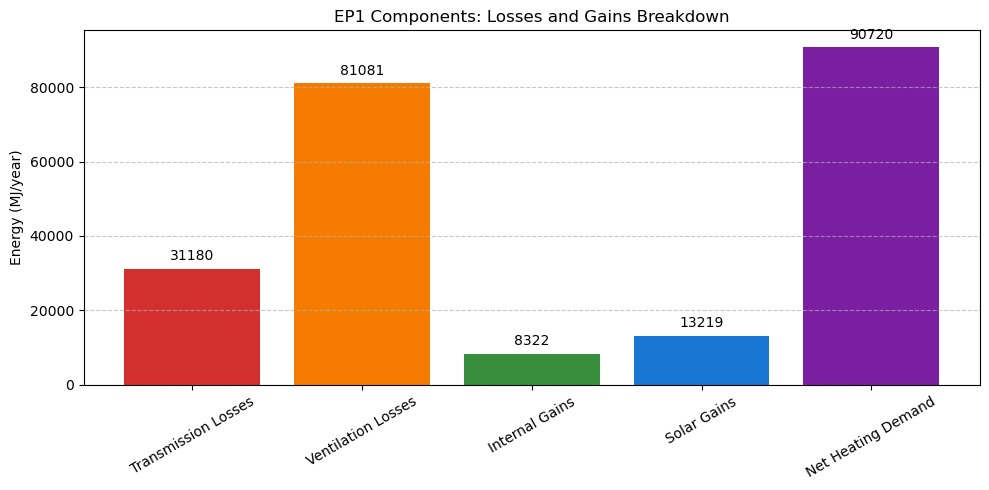

In [51]:
q_trans = calculate_transmission_losses(improved_building)
q_vent = calculate_ventilation_losses(improved_building)
q_internal = calculate_internal_gains(improved_building)
q_solar = calculate_solar_gains(improved_building)
net_heating = max(q_trans + q_vent - q_internal - q_solar, 0)

# --- Plot Bar Chart ---
components = ['Transmission Losses', 'Ventilation Losses', 'Internal Gains', 'Solar Gains', 'Net Heating Demand']
values = [q_trans, q_vent, q_internal, q_solar, net_heating]
colors = ['#d32f2f', '#f57c00', '#388e3c', '#1976d2', '#7b1fa2']

plt.figure(figsize=(10, 5))
bars = plt.bar(components, values, color=colors)
plt.ylabel("Energy (MJ/year)")
plt.title("EP1 Components: Losses and Gains Breakdown")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1500, f'{height:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### EP1 Final vs Primary Energy

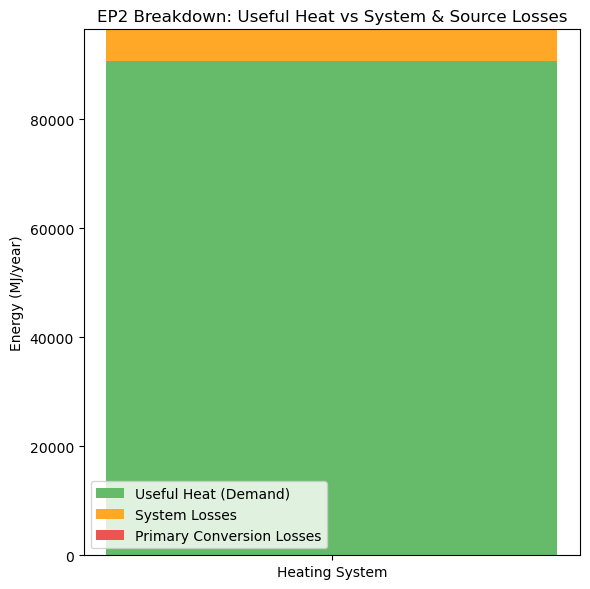

In [65]:
q_net_heating, q_final_energy, q_primary_energy = calculate_ep2_components(improved_building, gas_boiler)

# Plot stacked bar chart
plt.figure(figsize=(6, 6))
plt.bar("Heating System", q_net_heating, label="Useful Heat (Demand)", color="#66bb6a")
plt.bar("Heating System", q_final_energy - q_net_heating, bottom=q_net_heating, label="System Losses", color="#ffa726")
plt.bar("Heating System", q_primary_energy - q_final_energy, bottom=q_final_energy, label="Primary Conversion Losses", color="#ef5350")

plt.ylabel("Energy (MJ/year)")
plt.title("EP2 Breakdown: Useful Heat vs System & Source Losses")
plt.legend()
plt.tight_layout()
plt.show()

### EP2 vs EP# comparison

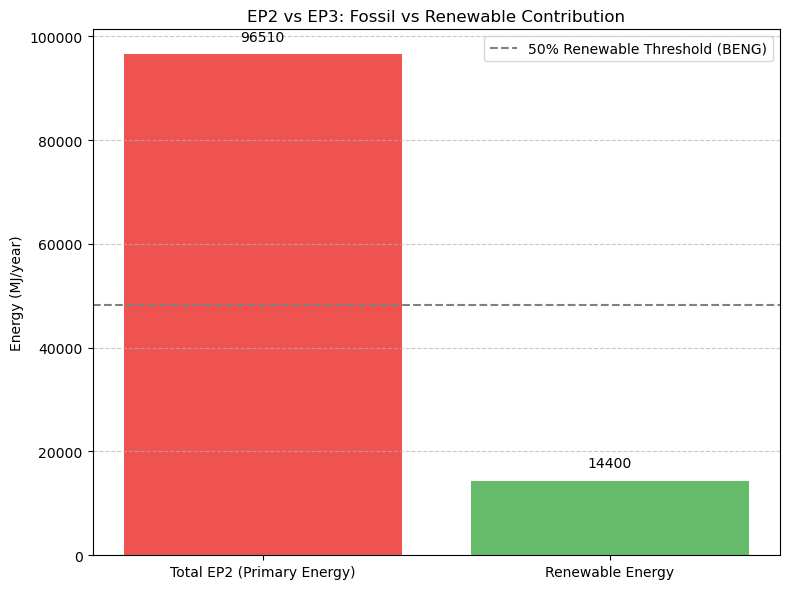

In [72]:
ep2_total_mj = q_primary_energy
renewable_mj = pv.annual_production_kwh * 3.6

# Plot EP2 vs Renewable Contribution
plt.figure(figsize=(8, 6))
bars = plt.bar(["Total EP2 (Primary Energy)", "Renewable Energy"], [ep2_total_mj, renewable_mj],
               color=["#ef5350", "#66bb6a"])
plt.title("EP2 vs EP3: Fossil vs Renewable Contribution")
plt.ylabel("Energy (MJ/year)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bar values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2000, f'{height:.0f}', ha='center', va='bottom')

# Add BENG threshold line at 50% renewable share
plt.axhline(ep2_total_mj * 0.5, color='gray', linestyle='--', label='50% Renewable Threshold (BENG)')
plt.legend()
plt.tight_layout()
plt.show()